In [9]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from scipy import signal
from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot
from pmdarima.arima.utils import ndiffs
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
from pmdarima import acf
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=ValueError)

In [10]:
df = pd.read_csv('G:/My Drive/IN/Data/Prophet/amazon.csv', parse_dates=['week'])
df = df[df['client_name'] == 'KIND']
df = df.drop_duplicates(subset=['sales', 'week'])
df['week'] = df['week'] = pd.to_datetime(df['week'])
df = df.sort_values(by=['week'])
df['sales'] = df['sales'].values
df['index'] = df['week']
df.set_index('index', inplace=True)
df = df[['week','sales']]

The following metrics are excellent in different situations; for example, RMSE is
excellent for comparing similar models.

In [11]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'MAPE':mape, 'ME':me, 'MAE': mae,
            'MPE': mpe, 'RMSE':rmse,
            'corr':corr, 'minmax':minmax})

There are three parameters of interest for an ARIMA model: d,p, and q. D refers to
differencing each previous value to make the model stationary. P is the term used
for how many lags can be used for prediction. Q is the order of moving average
to improve the model.

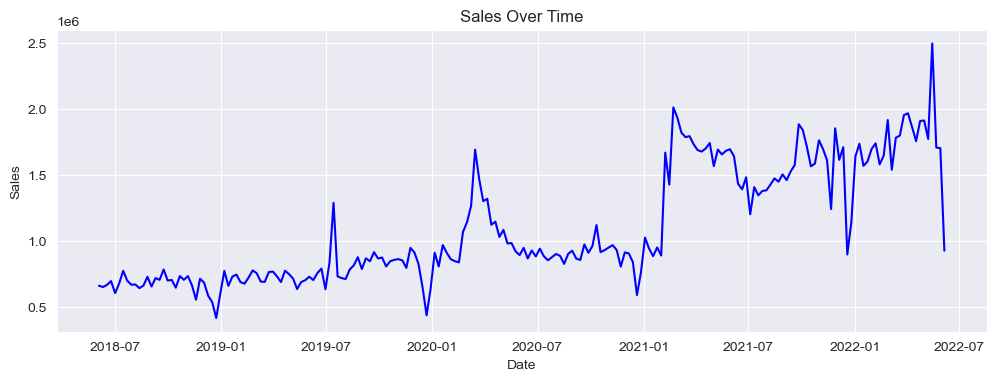

In [12]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Sales', dpi=100):
    plt.figure(figsize=(12, 4), dpi=dpi)
    plt.plot(x, y, color='blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
plot_df(df, df['week'], df['sales'], title='Sales Over Time')

An increasing trend is clearly visible, though the sesaonality is not
quite as obvious, so we will test for it later.

The Augmented Dickey-Fuller Test checks for the important
condition of stationarity. This test has failed, meaning we have to
correct for non-stationarity.

In [13]:
adf_test = ADFTest(alpha = .05)
adf_test.should_diff(df['sales'])

(0.03544219371758603, False)

In [14]:
train = df[:170]
test = df[-40:]
plt.plot(train)
plt.plot(test)

ValueError: year 10000 is out of range

<Figure size 432x288 with 1 Axes>

Value = Base Level + Trend + Seasonality + Error - Additive Decomposition
Value = Base Level x Trend x Seasonality x Error - Multiplicative Decompisition

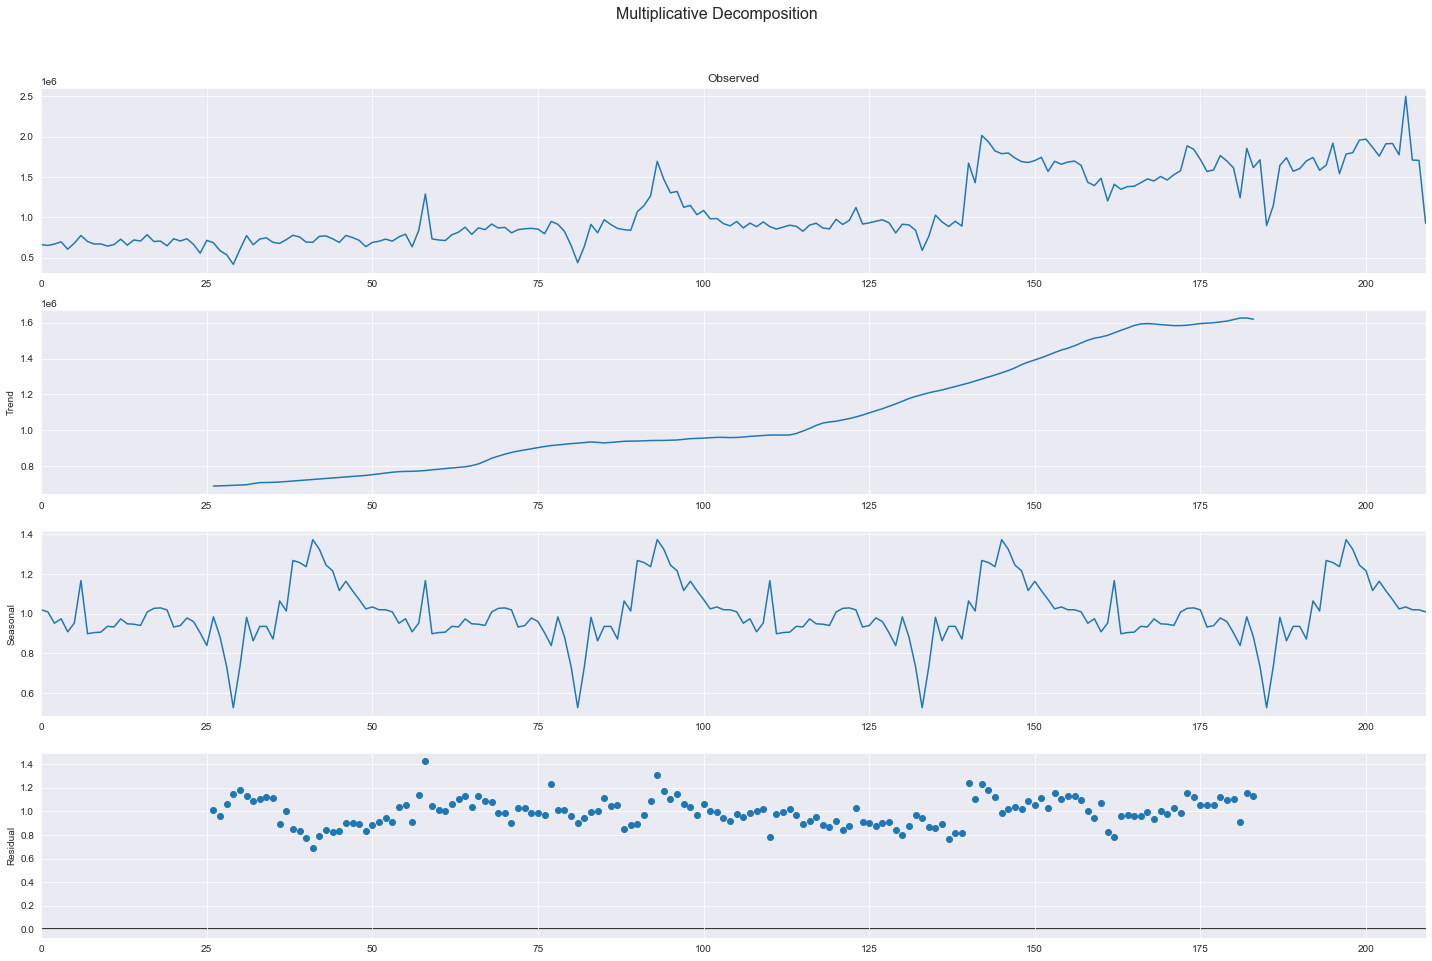

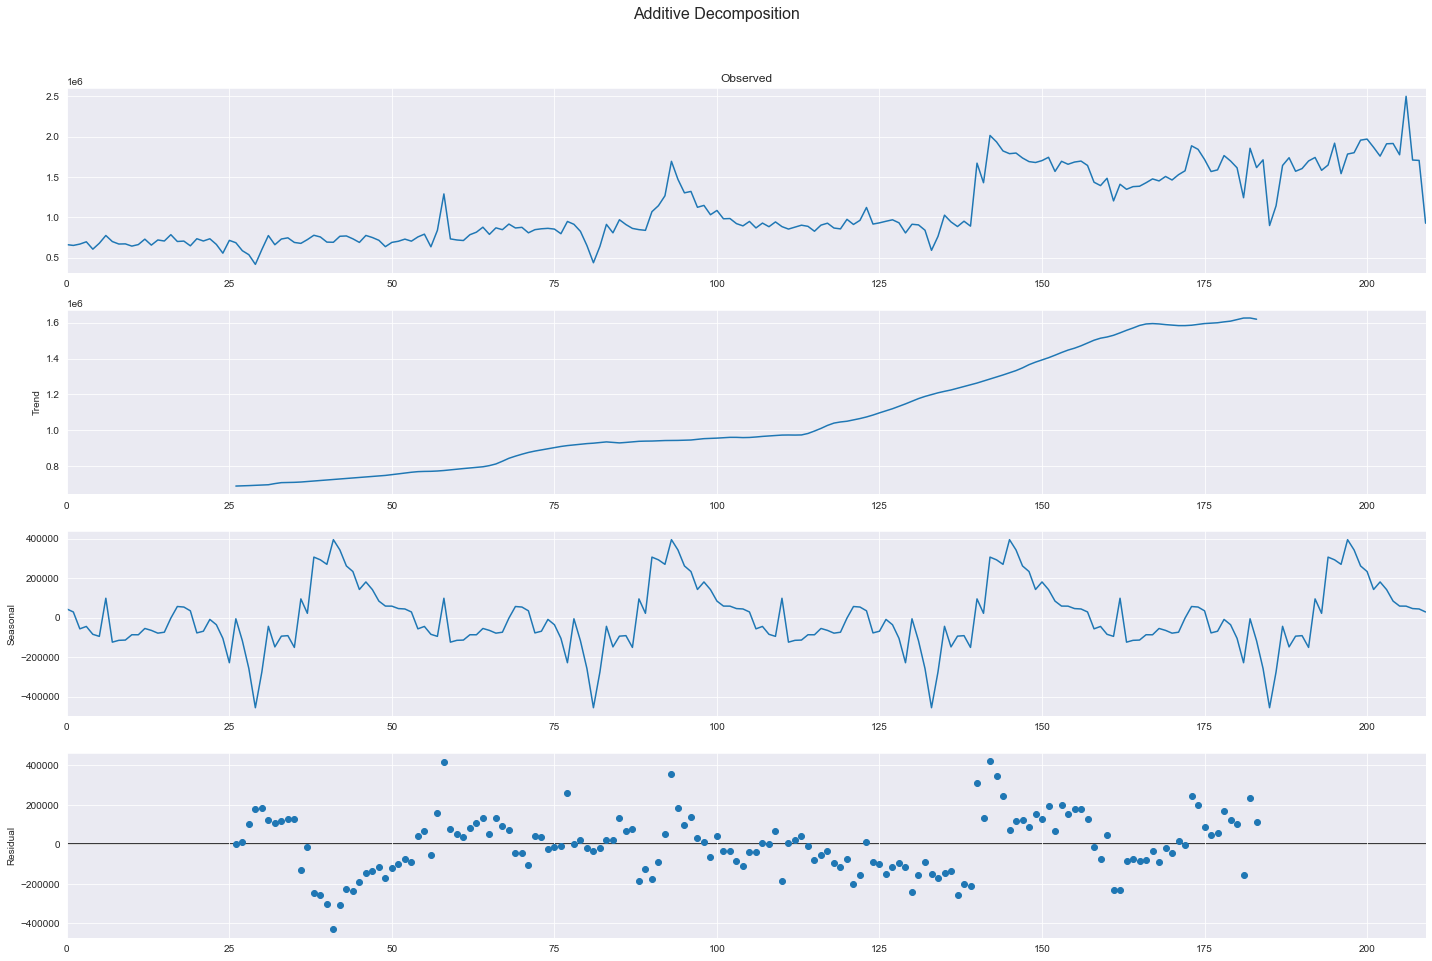

In [15]:
multiplicative_decomposition = seasonal_decompose(df['sales'].values,
                                                  model='multiplicative',
                                                  period=52)
additive_decomposition = seasonal_decompose(df['sales'].values, model='additive',
                                            period=52)
plt.rcParams.update({'figure.figsize': (20,14)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Both plots have a positive trend and display some seasonality, but the additive
seems to have significantly better reesiduals.

Text(0.5, 1.0, 'Sales Detrended')

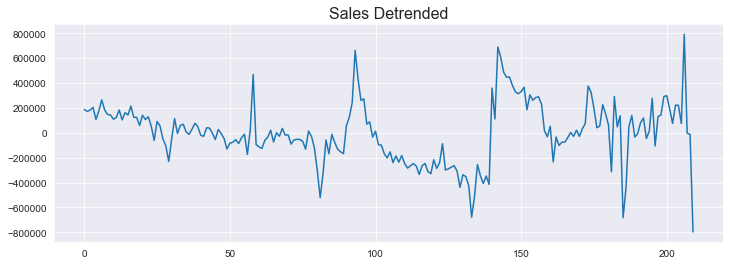

In [16]:
detrended = signal.detrend(df['sales'].values)
plt.rcParams.update({'figure.figsize': (12,4)})
plt.plot(detrended)
plt.title('Sales Detrended', fontsize=16)

The plot no longer seems to be increasing in trend, hence we have detrended it.

[]

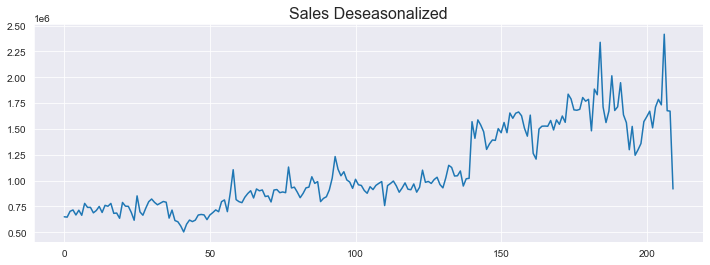

In [17]:
result_mul = seasonal_decompose(df['sales'].values, model='multiplicative', period=52)
deseasonalized = df['sales'].values / result_mul.seasonal
plt.plot(deseasonalized)
plt.title('Sales Deseasonalized', fontsize=16)
plt.plot()

The plot does not show a strong removal of seasonality, so move on to some testing

The following plot does not have any drastic spikes that suggest strong seasonality.

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

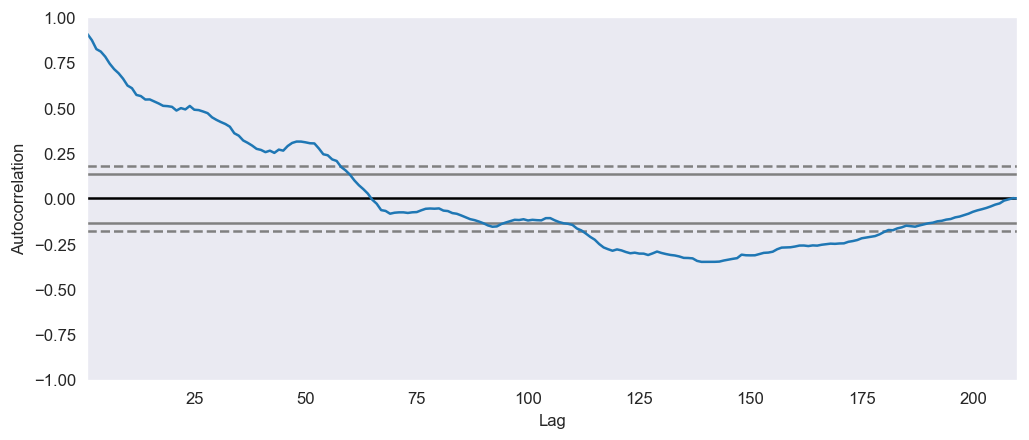

In [18]:
plt.rcParams.update({'figure.figsize':(10,4), 'figure.dpi':120})
autocorrelation_plot(df['sales'].tolist())

Autocorrelation refers to correlation of a series to its own lags. Partial autocorrelation
refers to the correlation to a lag without reference to the lags between.

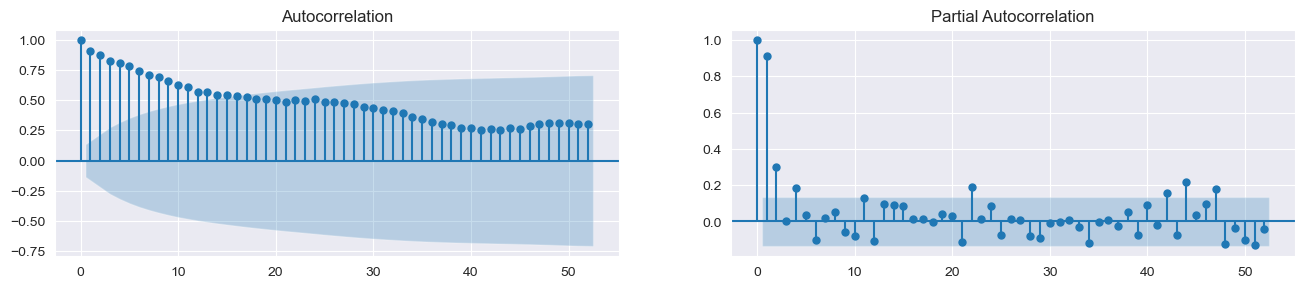

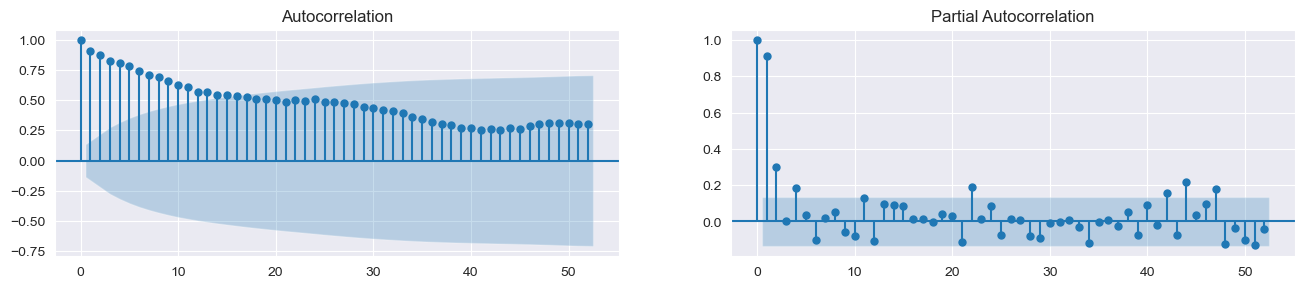

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(16, 3), dpi=100)
plot_acf(df['sales'].tolist(), lags=52, ax=axes[0])
plot_pacf(df['sales'].tolist(), lags=52, ax=axes[1])

Along with the above plots, the following metrics will quantify each degree of
lag. Perfect autocorrelation is one, and positive means that the next value in
the series will likely be higher.

In [20]:
ac1 = df['sales'].autocorr(lag=1)
print("One week Lag: ", ac1)
ac2 = df['sales'].autocorr(lag=2)
print("Two week Lag: ", ac2)
ac3 = df['sales'].autocorr(lag=3)
print("Three week Lag: ", ac3)
ac4 = df['sales'].autocorr(lag=4)
print("Four Week Lag: ", ac4)
ac5 = df['sales'].autocorr(lag=5)
print("Five Week Lag: ", ac5)
ac6 = df['sales'].autocorr(lag=6)
print("Six Week Lag: ", ac6)
ac7 = df['sales'].autocorr(lag=7)
print("Seven Week Lag: ", ac7)
ac8 = df['sales'].autocorr(lag=8)
print("Eight Week Lag: ", ac8)
ac9 = df['sales'].autocorr(lag=9)
print("Nine Week Lag: ", ac9)
ac10 = df['sales'].autocorr(lag=10)
print("Ten Week Lag: ", ac10)
ac11 = df['sales'].autocorr(lag=11)
print("Eleven Week Lag: ", ac11)
ac12 = df['sales'].autocorr(lag=12)
print("Twelve Week Lag: ", ac12)

One week Lag:  0.9098153102363996
Two week Lag:  0.8821806039294658
Three week Lag:  0.8389246955797052
Four Week Lag:  0.8490497092696656
Five Week Lag:  0.8279749295809786
Six Week Lag:  0.7972397702030306
Seven Week Lag:  0.7741044310663452
Eight Week Lag:  0.7569161243131864
Nine Week Lag:  0.7337078457624799
Ten Week Lag:  0.7031688420379569
Eleven Week Lag:  0.6983477370843815
Twelve Week Lag:  0.6648409440726897


These twelve weeks rather strong logs show that autocorrelation is somethng to
be mindful in this model.

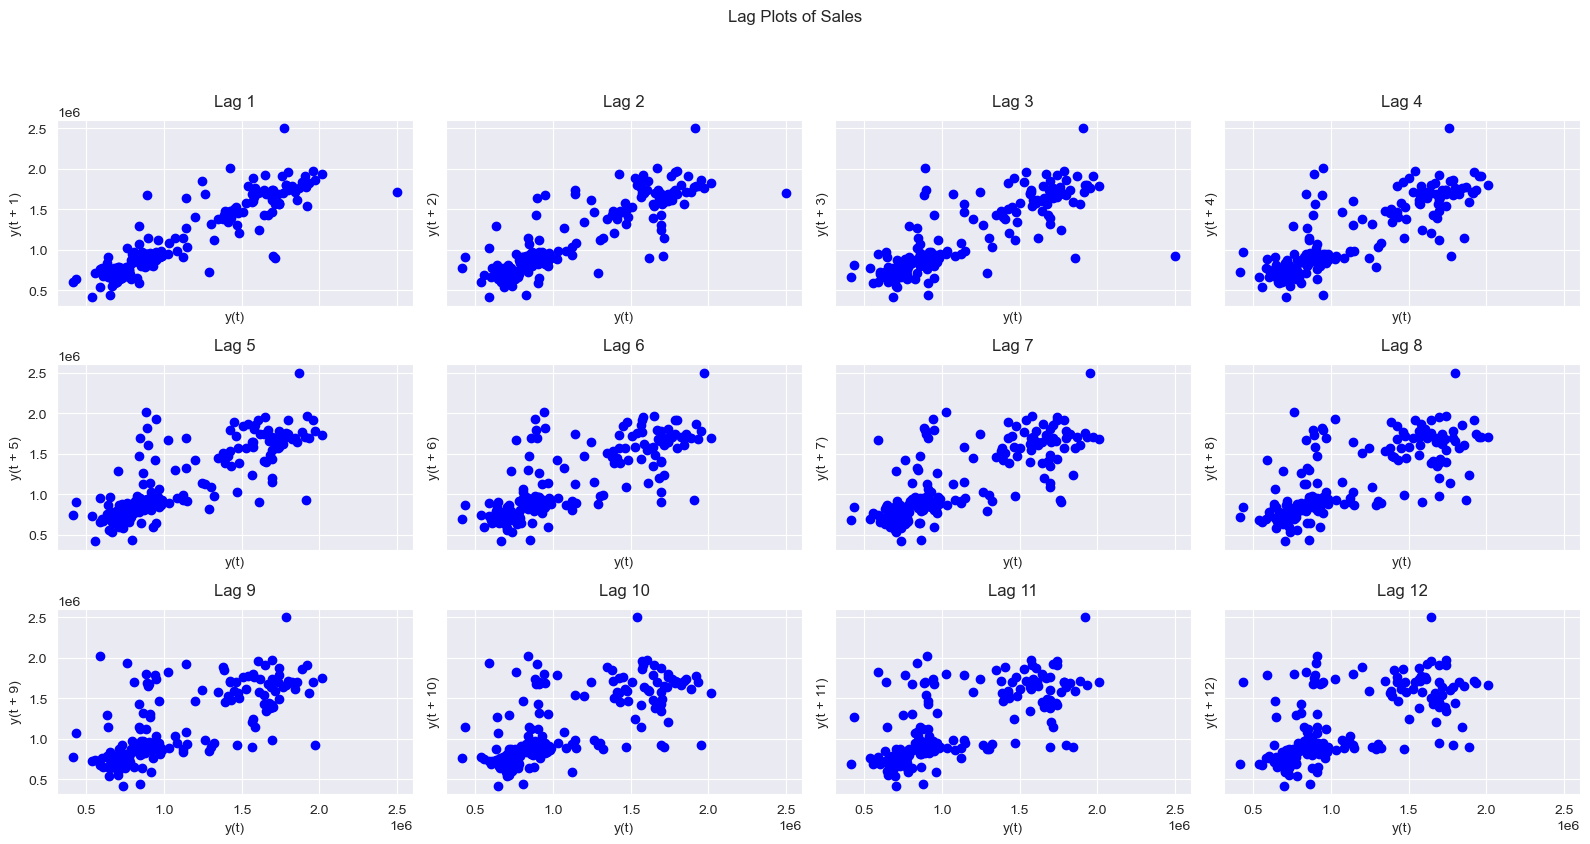

In [21]:
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})
fig, axes = plt.subplots(3, 4, figsize=(16, 8), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:12]):
    lag_plot(df['sales'], lag=i+1, ax=ax, c='blue')
    ax.set_title('Lag ' + str(i+1))
fig.suptitle('Lag Plots of Sales', y=1.05)
fig.tight_layout()
plt.show()

Decreasing linear trend between lag plots demonstrates similar results to
lag scores, suggesting some positive autocorrelation between first week

In [22]:
train = df['sales'][:105]
test = df['sales'][105:]
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2735.958, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2735.427, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2734.359, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2733.997, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2731.299, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2733.092, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2733.220, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2732.727, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2733.998, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2730.136, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2732.487, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2733.508, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2731.985, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : 

SARIMAX MODEL

C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
C:\Anaconda\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


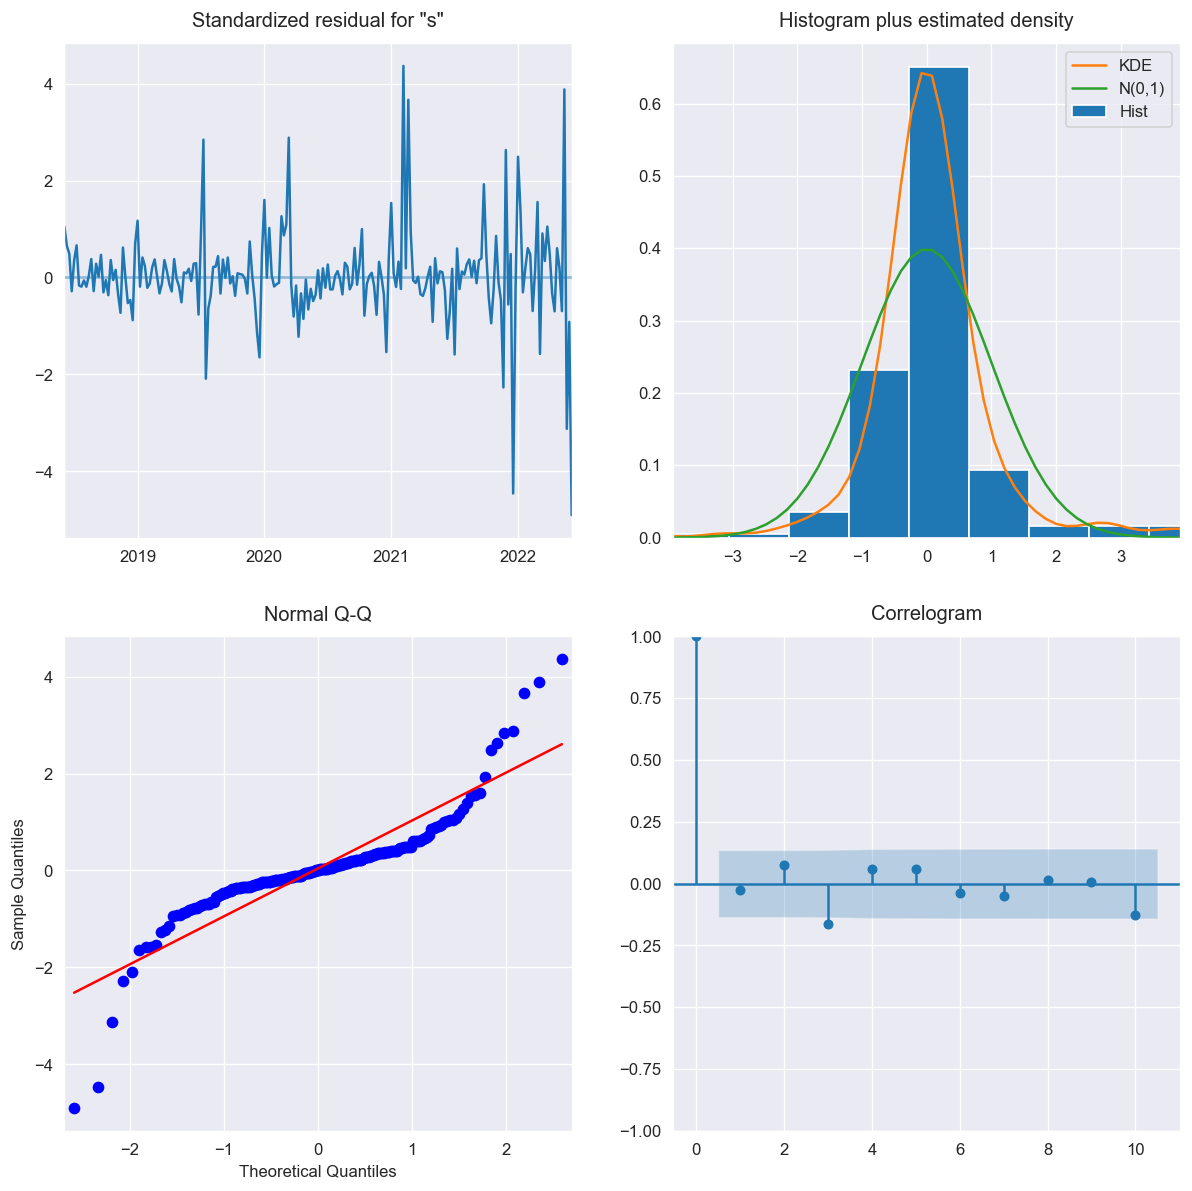

In [23]:
mod = sm.tsa.statespace.SARIMAX(df['sales'],
                                order=(1, 1, 1),
                                seasonal_order=(0, 0, 0, 0),
                                enforce_stationarity=True,
                                enforce_invertibility=True,
                                freq='W')
results = mod.fit()
results.plot_diagnostics(figsize=(12, 12))
plt.show()

SARIMAX Diagnostics

In [24]:
forecast = forecast.squeeze()
forecast_accuracy(forecast, test)

{'MAPE': 0.2932394057471121,
 'ME': -391765.99632610887,
 'MAE': 461968.9900002244,
 'MPE': -0.20872279356631948,
 'RMSE': 560440.7130650621,
 'corr': 0.2833033634806505,
 'minmax': 0.2860653949138777}

In [25]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                  210
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2818.702
Date:                Wed, 03 Aug 2022   AIC                           5643.405
Time:                        02:09:17   BIC                           5653.432
Sample:                    06-03-2018   HQIC                          5647.459
                         - 06-05-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1741      0.144      1.209      0.227      -0.108       0.456
ma.L1         -0.5354      0.123     -4.343      0.000      -0.777      -0.294
sigma2      3.096e+10   6.77e-12   4.57e+21      0.000     3.1e+10     3.1e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):               555.08
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               6.06   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.89e+37. Standard errors may be unstable.
"""

In [26]:
df_small = df[['week', 'sales']]

In [27]:
result = adfuller(df_small.sales.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.760572
p-value: 0.400205


In this case, we fail the ADF test and will examine differencing
as a method to make our series stationary,

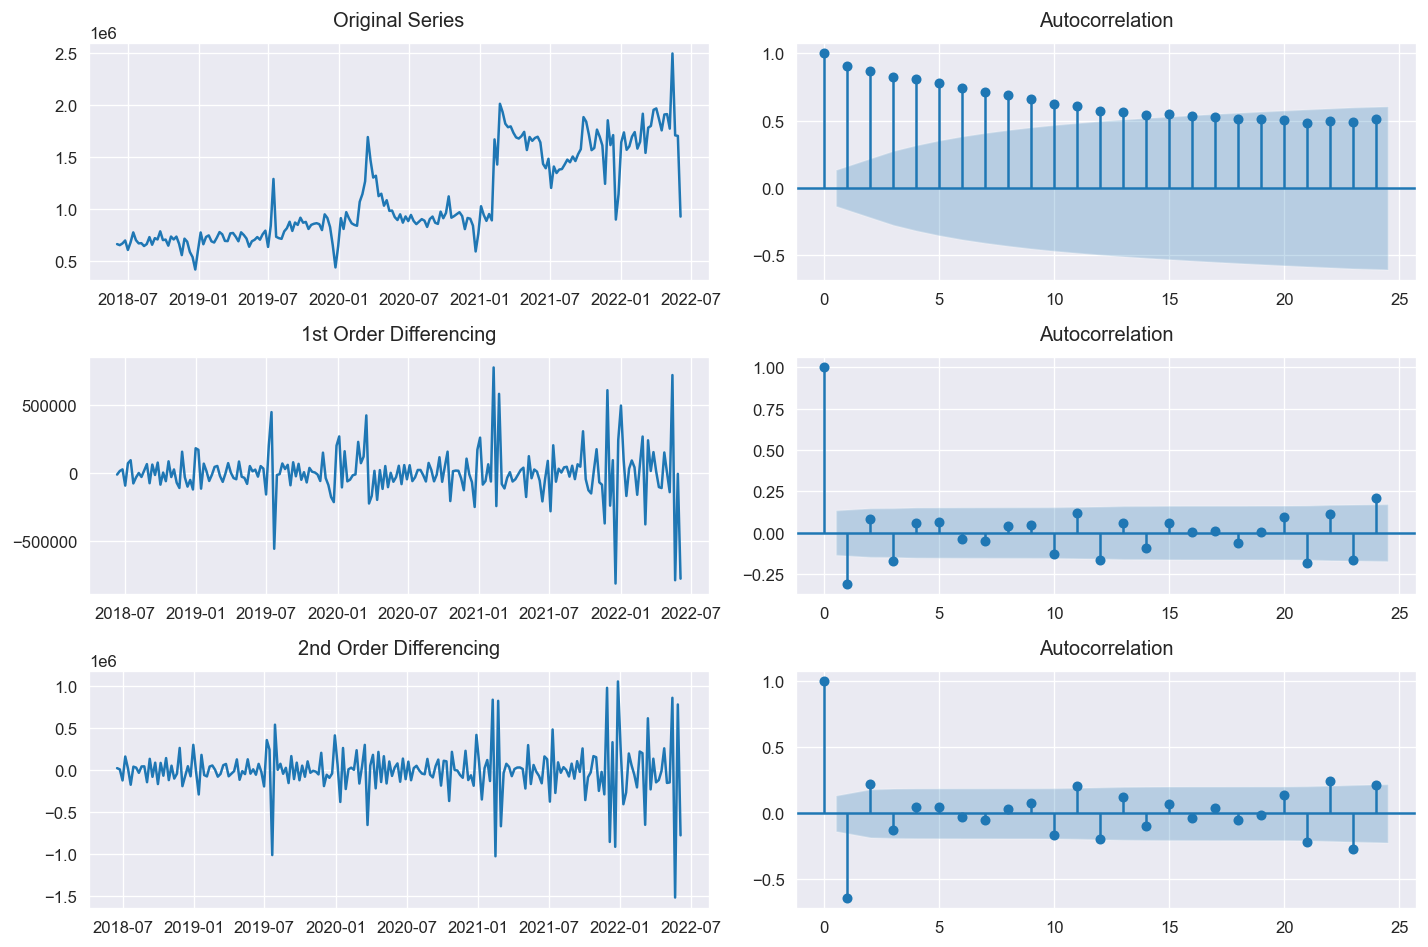

In [28]:
plt.rcParams.update({'figure.figsize':(12,8), 'figure.dpi':120})

fig, axes = plt.subplots(3, 2, sharex=False)
axes[0, 0].plot(df_small.sales); axes[0, 0].set_title('Original Series')
plot_acf(df_small.sales, ax=axes[0, 1])

axes[1, 0].plot(df_small.sales.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_small.sales.diff().dropna(), ax=axes[1, 1])

axes[2, 0].plot(df_small.sales.diff().diff()); axes[2, 0].set_title('2nd Order '
                                                                  'Differencing')
plot_acf(df_small.sales.diff().diff().dropna(), ax=axes[2, 1])
fig.tight_layout()
plt.show()

By the time the first differencing plot and its correlation plot, we can see
that the model has achieved a decent amount of stationarity.

In [29]:
# Fix Training and Test Data for Remaining Functions
df_small = df_small.sort_values(by=['week'])
df_model = df_small.set_index('week')
df_small = df_small.reset_index()
df_small = df_small[['week', 'sales']]
train = df_small['sales'][:105]
test = df_small['sales'][105:]
train_model = df_model['sales'][:105]
test_model = df_model['sales'][105:]

Now we will test the auto_arima model to see if it performs better.

In [30]:
train = df_model['sales']
arima_model = auto_arima(train, start_p=0, d=1, start_q=0, max_p=5,
                         max_d=5, max_q=5, start_P=0, D=1, start_Q=0,
                         max_P=5, max_D=5, max_Q=5, m=12, seasonal=True,
                         error_action='warn', trace=True,
                         suppress_warnings=True, stepwise=True,
                         random_state=13, n_fits=50)
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5493.345, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5392.848, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5387.578, Time=0.19 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=5471.018, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=5382.086, Time=0.27 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=5394.899, Time=0.18 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=5383.627, Time=0.66 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=5383.099, Time=0.73 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=5383.368, Time=0.40 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=5390.015, Time=0.29 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=5385.047, Time=1.13 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=5362.245, Time=0.20 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=5392.904, Time=0.11 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=5383.421, Time=0.13 sec
 ARIMA(0,1,0)(2,1,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  210
Model:             SARIMAX(0, 1, 0)x(4, 1, [1], 12)   Log Likelihood               -2673.047
Date:                              Wed, 03 Aug 2022   AIC                           5358.094
Time:                                      02:10:07   BIC                           5377.793
Sample:                                           0   HQIC                          5366.068
                                              - 210                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.3743      0.285     -1.312      0.190      -0.934       0.185
ar.S.L24       0.0203      0.291      0.070      0.944      -0.551       0.591
ar.S.L36      -0.1864      0.188     -0.991      0.321      -0.555       0.182
ar.S.L48      -0.0827      0.155     -0.533      0.594      -0.387       0.221
ma.S.L12      -0.7133      0.290     -2.457      0.014      -1.282      -0.144
sigma2       3.94e+10   1.55e-11   2.54e+21      0.000    3.94e+10    3.94e+10
===================================================================================
Ljung-Box (L1) (Q):                  13.79   Jarque-Bera (JB):               164.28
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.90   Skew:                             0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.4e+36. Standard errors may be unstable.
"""

In [31]:
train = df_model['sales'][:160]
test = df_model['sales'][-50:]
prediction = pd.DataFrame(arima_model.predict(n_periods=50), index=test.index)
shift = test.iloc[0] - prediction.iloc[0,0]
prediction = prediction + shift

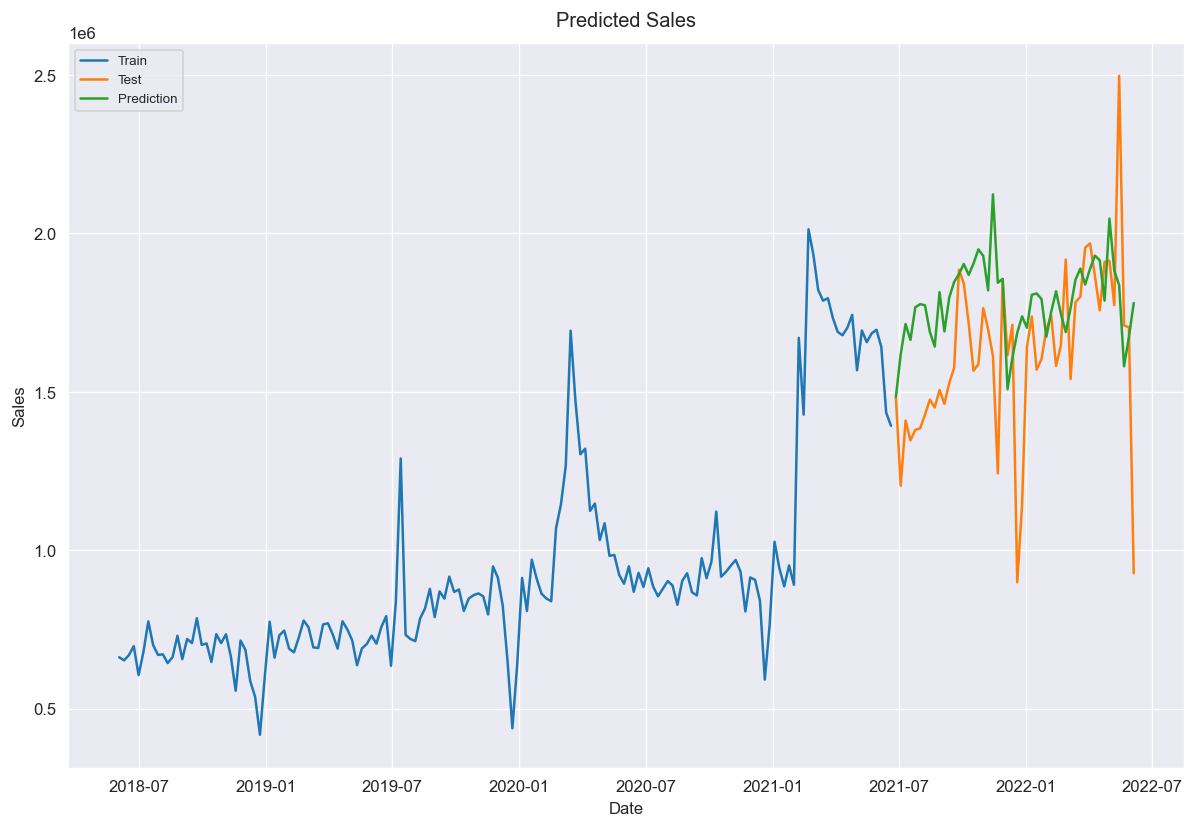

In [32]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(prediction, label='Prediction')
plt.title('Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Arima Model Statistics

In [33]:
prediction = prediction.squeeze()
forecast_accuracy(prediction, test)

{'MAPE': 0.16577418594053547,
 'ME': 166761.96535185922,
 'MAE': 231498.84744035546,
 'MPE': 0.13414035105020955,
 'RMSE': 305382.9726881493,
 'corr': 0.33824785530978446,
 'minmax': 0.12682113756631053}

Note the RMSE is significantly higher in the second model.

Just to demonstrate one more train/test plot with error
above and below, voila.

In [34]:
def forecast_to_df(model, steps=12):
    forecast = model.get_forecast(steps=steps)
    pred_df = forecast.conf_int()
    pred_df['pred'] = forecast.predicted_mean
    pred_df.columns = ['lower', 'upper', 'pred']
    return pred_df

In [35]:
pred_df = forecast_to_df(results, steps = len(test))

pred = pred_df['pred']

(<Figure size 1440x840 with 1 Axes>,
 <AxesSubplot:title={'center':'Model Validation'}>)

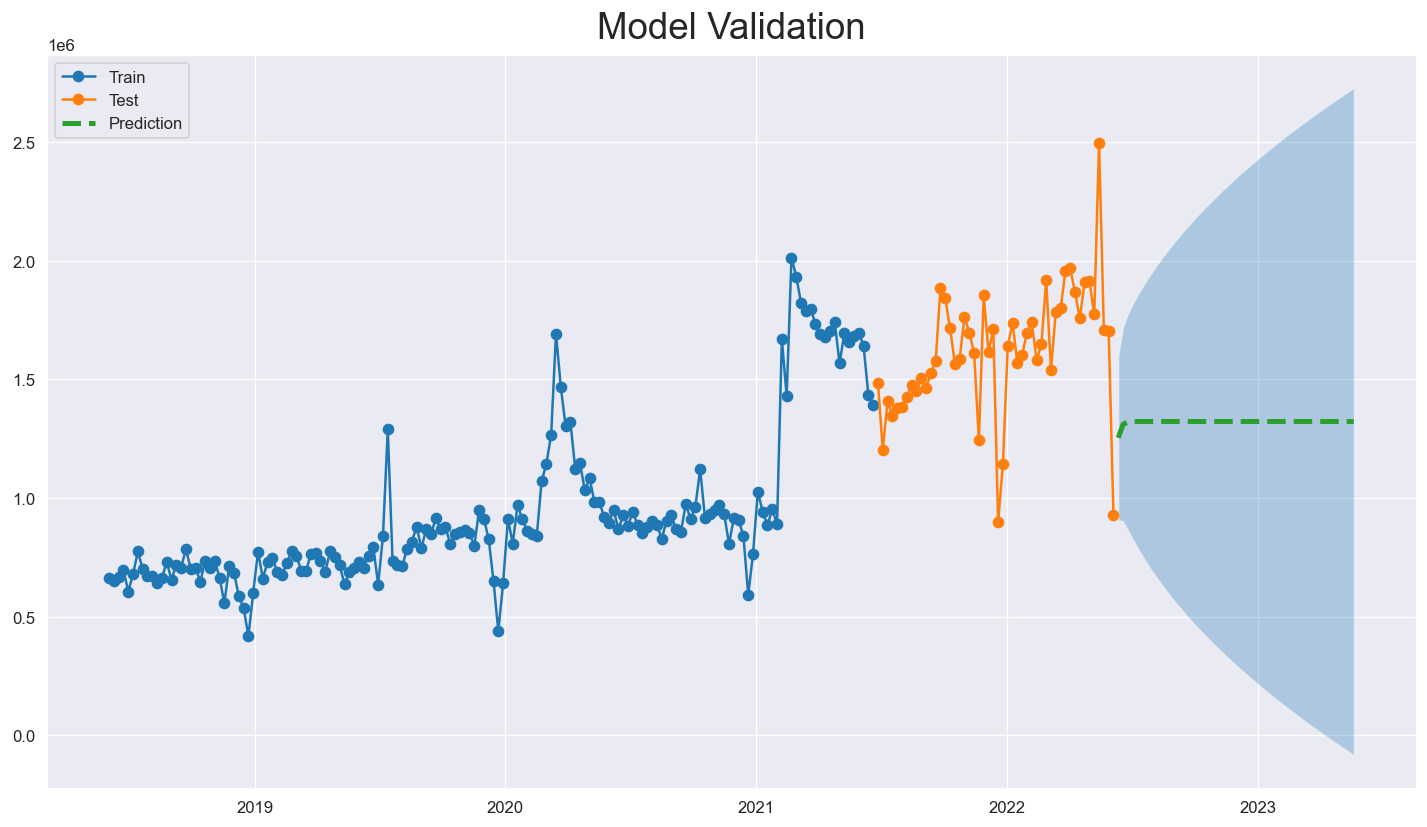

In [36]:
def plot_train_test_pred(train,test,pred_df):
    fig,ax = plt.subplots(figsize=(12,7))
    kws = dict(marker='o')

    ax.plot(train,label='Train',**kws)
    ax.plot(test,label='Test',**kws)
    ax.plot(pred_df['pred'],label='Prediction',ls='--',linewidth=3)

    ax.fill_between(x=pred_df.index,y1=pred_df['lower'],y2=pred_df['upper'],alpha=0.3)
    ax.set_title('Model Validation', fontsize=22)
    ax.legend(loc='upper left')
    fig.tight_layout()
    return fig,ax

plot_train_test_pred(train, test, pred_df)